In [1]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
import itertools
from tqdm import tqdm
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore
import matplotlib.lines as mlines

tqdm.pandas()

# Load in the top features

In [2]:
#General model features
addiction_general = pd.read_csv('features/top_features_general.csv') #0.94 accuracy
alcohol_general = pd.read_csv('features/alcohol_top_features_general.csv') #0.89 accuracy

#Node type model features
addiction_nt = pd.read_csv('features/top_features_nt.csv') #0.94 accuracy
addiction_nt = addiction_nt.sort_values('importance', ascending=False).reset_index(drop=True)

alcohol_nt = pd.read_csv('features/alcohol_top_features_nt.csv') #0.96 accuracy
alcohol_nt = alcohol_nt.sort_values('importance', ascending = False).reset_index(drop=True)


In [3]:
addiction_general['ranked_importance'] = addiction_general.index
addiction_nt['ranked_importance'] = addiction_nt.index

alcohol_general['ranked_importance'] = alcohol_general.index
alcohol_nt['ranked_importance'] = alcohol_nt.index

column_order = ['node','type', 'ranked_importance_opioid', 'ranked_importance_alcohol', 'importance_opioid', 'importance_alcohol']

# See which features overlap

In [5]:
#common nodes general
common_features_general = pd.merge(addiction_general, alcohol_general.drop('type', axis = 1), on = 'node', how = 'inner', suffixes = ('_opioid', '_alcohol'))[column_order]
common_features_general

,node,type,ranked_importance_opioid,ranked_importance_alcohol,importance_opioid,importance_alcohol
0,CHEMBL1200703,Compound,4,137,0.000316,0.000571
1,Q8IZ26,Protein,91,14,0.000151,0.002090
2,CHEMBL1760599,Compound,109,131,0.000147,0.000616
3,CHEMBL2204440,Compound,110,50,0.000147,0.001678
4,CHEMBL982,Compound,179,130,0.000132,0.000618
5,CHEMBL1213898,Compound,197,167,0.000128,0.000450
6,CHEMBL1774918,Compound,227,228,0.000125,0.000355
7,CHEMBL3234759,Compound,238,158,0.000124,0.000464


In [6]:
#common nodes nt specific
common_features_nt = pd.merge(addiction_nt, alcohol_nt.drop('type', axis = 1), on = 'node', how = 'inner', suffixes = ('_opioid', '_alcohol'))[column_order]
common_features_nt

,node,type,ranked_importance_opioid,ranked_importance_alcohol,importance_opioid,importance_alcohol
0,N0000175706,PharmacologicClass,1,94,0.000771,0.000737
1,N0000006496,PharmacologicClass,3,90,0.000582,0.001022
2,CHEBI:35471,PharmacologicClass,10,135,0.000391,0.000318
3,D005731,PharmacologicClass,12,88,0.000383,0.001450
4,414919,Gene,21,2,0.000306,0.012496
5,DOID:0050742,Disease,23,96,0.000299,0.000718
6,D018722,PharmacologicClass,24,92,0.000299,0.000798
7,389158,Gene,30,24,0.000278,0.002963
8,DOID:0070089,Disease,31,144,0.000278,0.000292
9,C0001973,SideEffect,33,0,0.000276,0.015848


In [11]:
#Get the features that are unique to each disease

opioid_specific_general = addiction_general[~addiction_general['node'].isin(common_features_general['node'])]
alcohol_specific_general = alcohol_general[~alcohol_general['node'].isin(common_features_general['node'])]

opioid_specific_nt = addiction_nt[~addiction_nt['node'].isin(common_features_nt['node'])]
alcohol_specific_nt = alcohol_nt[~alcohol_nt['node'].isin(common_features_nt['node'])]

# Map back to SPOKE

In [24]:
# Add identifier column to create graph visualization
mapped_nodes = pd.read_csv('all_nodes_addiction_mapped.csv').rename(columns={"Q9GZZ6":'node'})

def add_identifier_column(df):
    # Initialize the identifier column with empty strings
    df['identifier'] = ''
    
    # Process each row based on the type
    for index, row in df.iterrows():
        node_value = row['node']
        row_type = row['type']
        
        if row_type == 'Gene':
            # Convert the node value to an integer
            df.at[index, 'identifier'] = int(node_value)
        elif row_type == 'Compound':
            # Get the corresponding identifier from the mapped_node table
            mapped_value = mapped_nodes.loc[mapped_nodes['node'] == node_value, 'identifier']
            if not mapped_value.empty:
                df.at[index, 'identifier'] = mapped_value.values[0]
        elif row_type == 'Pathway':
            # Remove everything after the underscore (including the underscore)
            if '_' in node_value:
                id = node_value.split('_')[0]
                if id == 'PC7':
                    df.at[index, 'identifier'] = np.nan
                else:
                    df.at[index, 'identifier'] = id
            else:
                df.at[index, 'identifier'] = np.nan
        else:
            # Keep the node value as the identifier
            df.at[index, 'identifier'] = node_value
    
    return df

In [25]:
tables = [addiction_general, addiction_nt, alcohol_general, alcohol_nt, common_features_general, common_features_nt, opioid_specific_general, alcohol_specific_general, opioid_specific_nt, alcohol_specific_nt]

for t in tables:
    t = add_identifier_column(t)

/tmp/ipykernel_30397/167765346.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['identifier'] = ''


In [ ]:
# This gives the list of nodes to put into cypher query

cypher_query = []

for identifier in opioid_specific_nt['identifier'].dropna().tolist():
    if isinstance(identifier, int):
        cypher_query.append(str(identifier))
    else:
        cypher_query.append(f"'{identifier}'")
    
', '.join(cypher_query)


"'DOID:9975', 'DOID:809', 339778, 339512, 'DOID:302', 286052, 'DOID:0060166', 399949, 389763, 'DOID:1849', 10998, 116138, 206412, 'DOID:9505', 'DOID:6680', 158062, 'Q9GZZ6', 2913, 144809, 'DOID:303', 728819, 'DOID:778', 2578, 285812, 'D063387', 'inchikey:AKEWRXXBJJCYIL-UHFFFAOYSA-N', 'C0024117', 'DOID:3488', 'DOID:631', 'DOID:5419', 'N0000175496', 388780, 'DOID:0070091', 'C0029443', 497661, 'inchikey:SRWQVWAIVQXPJY-QGZVFWFLSA-N', 'DOID:3312', 'DOID:1019', 56986, 650293, 'DOID:11718', 'C0028043', 'DOID:0070093', 'F8WC51', 'inchikey:VFBLBKKMLKAPON-VFWMWCIBSA-N', 'N0000166489', 'C0152025', 'inchikey:CDNFAKVJGFHDDB-UHFFFAOYSA-N', 'chembl.compound:CHEMBL3545087', 'C0344315', 'D065690', 'C1167842', 'UBERON:0005413', 'P19801', 'inchikey:ILORKHQGIMGDFN-UHFFFAOYSA-N', 'D062706', 'Q3SY49', 'Q8TBB6', 'D000068760', 'D009767', 'GO:0031731', 'inchikey:VESATANJIWURSD-FIWHBWSRSA-N', 'inchikey:ZPZYOXJIFOEOCZ-UHFFFAOYSA-N', 'UBERON:4300186', 'UBERON:0001536', 'UBERON:0013076', 'CHEBI:59282', 'GO:0048302

# Create Visualizations

In [44]:
def create_barchart(datatable, n_nodes, title, highlight_nodes=None):
    palette = {
        'Anatomy': '#1f77b4',                  # Blue
        'BiologicalProcess': '#ff7f0e',        # Orange
        'CellularComponent': '#2ca02c',        # Green
        'Compound': '#d62728',                 # Red
        'Disease': '#9467bd',                  # Purple
        'Gene': '#8c564b',                     # Brown
        'MolecularFunction': '#e377c2',        # Pink
        'Pathway': '#7f7f7f',                  # Gray
        'PharmacologicClass': '#bcbd22',       # Yellow
        'Protein': '#17becf',                  # Teal
        'SideEffect': '#ffbb78',               # Light Orange
        'Symptom': '#9edae5'                   # Light Blue
    }
    
    plt.figure(figsize=(32, int(n_nodes * 2 / 5)))

    if highlight_nodes:
        # Create a list of colors where highlighted nodes are red and others are grey
        colors = ['red' if node in highlight_nodes else 'grey' for node in datatable['node'].iloc[:n_nodes]]
        sns.barplot(x='importance', y='node', data=datatable.iloc[:n_nodes], palette=colors, dodge=False)
    else:
        sns.barplot(x='importance', y='node', data=datatable.iloc[:n_nodes], hue='type', dodge=False, palette=palette)
    
    plt.xlabel('Ranked Importance')
    plt.ylabel('Node')
    plt.title(f'Node importance {title}')
    
    if highlight_nodes:
        # Create a custom legend
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color='red', lw=4),
                        Line2D([0], [0], color='grey', lw=4)]
        plt.legend(custom_lines, ['addiction_agnostic', title], title='Node Highlight', loc='lower right')
    else:
        plt.legend(title='Node Type', loc='lower right')

In [49]:
common_features_nt.head(10)

,node,type,ranked_importance_opioid,ranked_importance_alcohol,importance_opioid,importance_alcohol,identifier
0,N0000175706,PharmacologicClass,1,94,0.000771,0.000737,N0000175706
1,N0000006496,PharmacologicClass,3,90,0.000582,0.001022,N0000006496
2,CHEBI:35471,PharmacologicClass,10,135,0.000391,0.000318,CHEBI:35471
3,D005731,PharmacologicClass,12,88,0.000383,0.001450,D005731
4,414919,Gene,21,2,0.000306,0.012496,414919
5,DOID:0050742,Disease,23,96,0.000299,0.000718,DOID:0050742
6,D018722,PharmacologicClass,24,92,0.000299,0.000798,D018722
7,389158,Gene,30,24,0.000278,0.002963,389158
8,DOID:0070089,Disease,31,144,0.000278,0.000292,DOID:0070089
9,C0001973,SideEffect,33,0,0.000276,0.015848,C0001973


In [47]:
addiction_nt.head(30)

,importance,node,type,ranked_importance,identifier
0,0.000805,DOID:9975,Disease,0,DOID:9975
1,0.000771,N0000175706,PharmacologicClass,1,N0000175706
2,0.000766,DOID:809,Disease,2,DOID:809
3,0.000582,N0000006496,PharmacologicClass,3,N0000006496
4,0.000561,339778,Gene,4,339778
5,0.000540,339512,Gene,5,339512
6,0.000463,DOID:302,Disease,6,DOID:302
7,0.000462,286052,Gene,7,286052
8,0.000408,DOID:0060166,Disease,8,DOID:0060166
9,0.000400,399949,Gene,9,399949


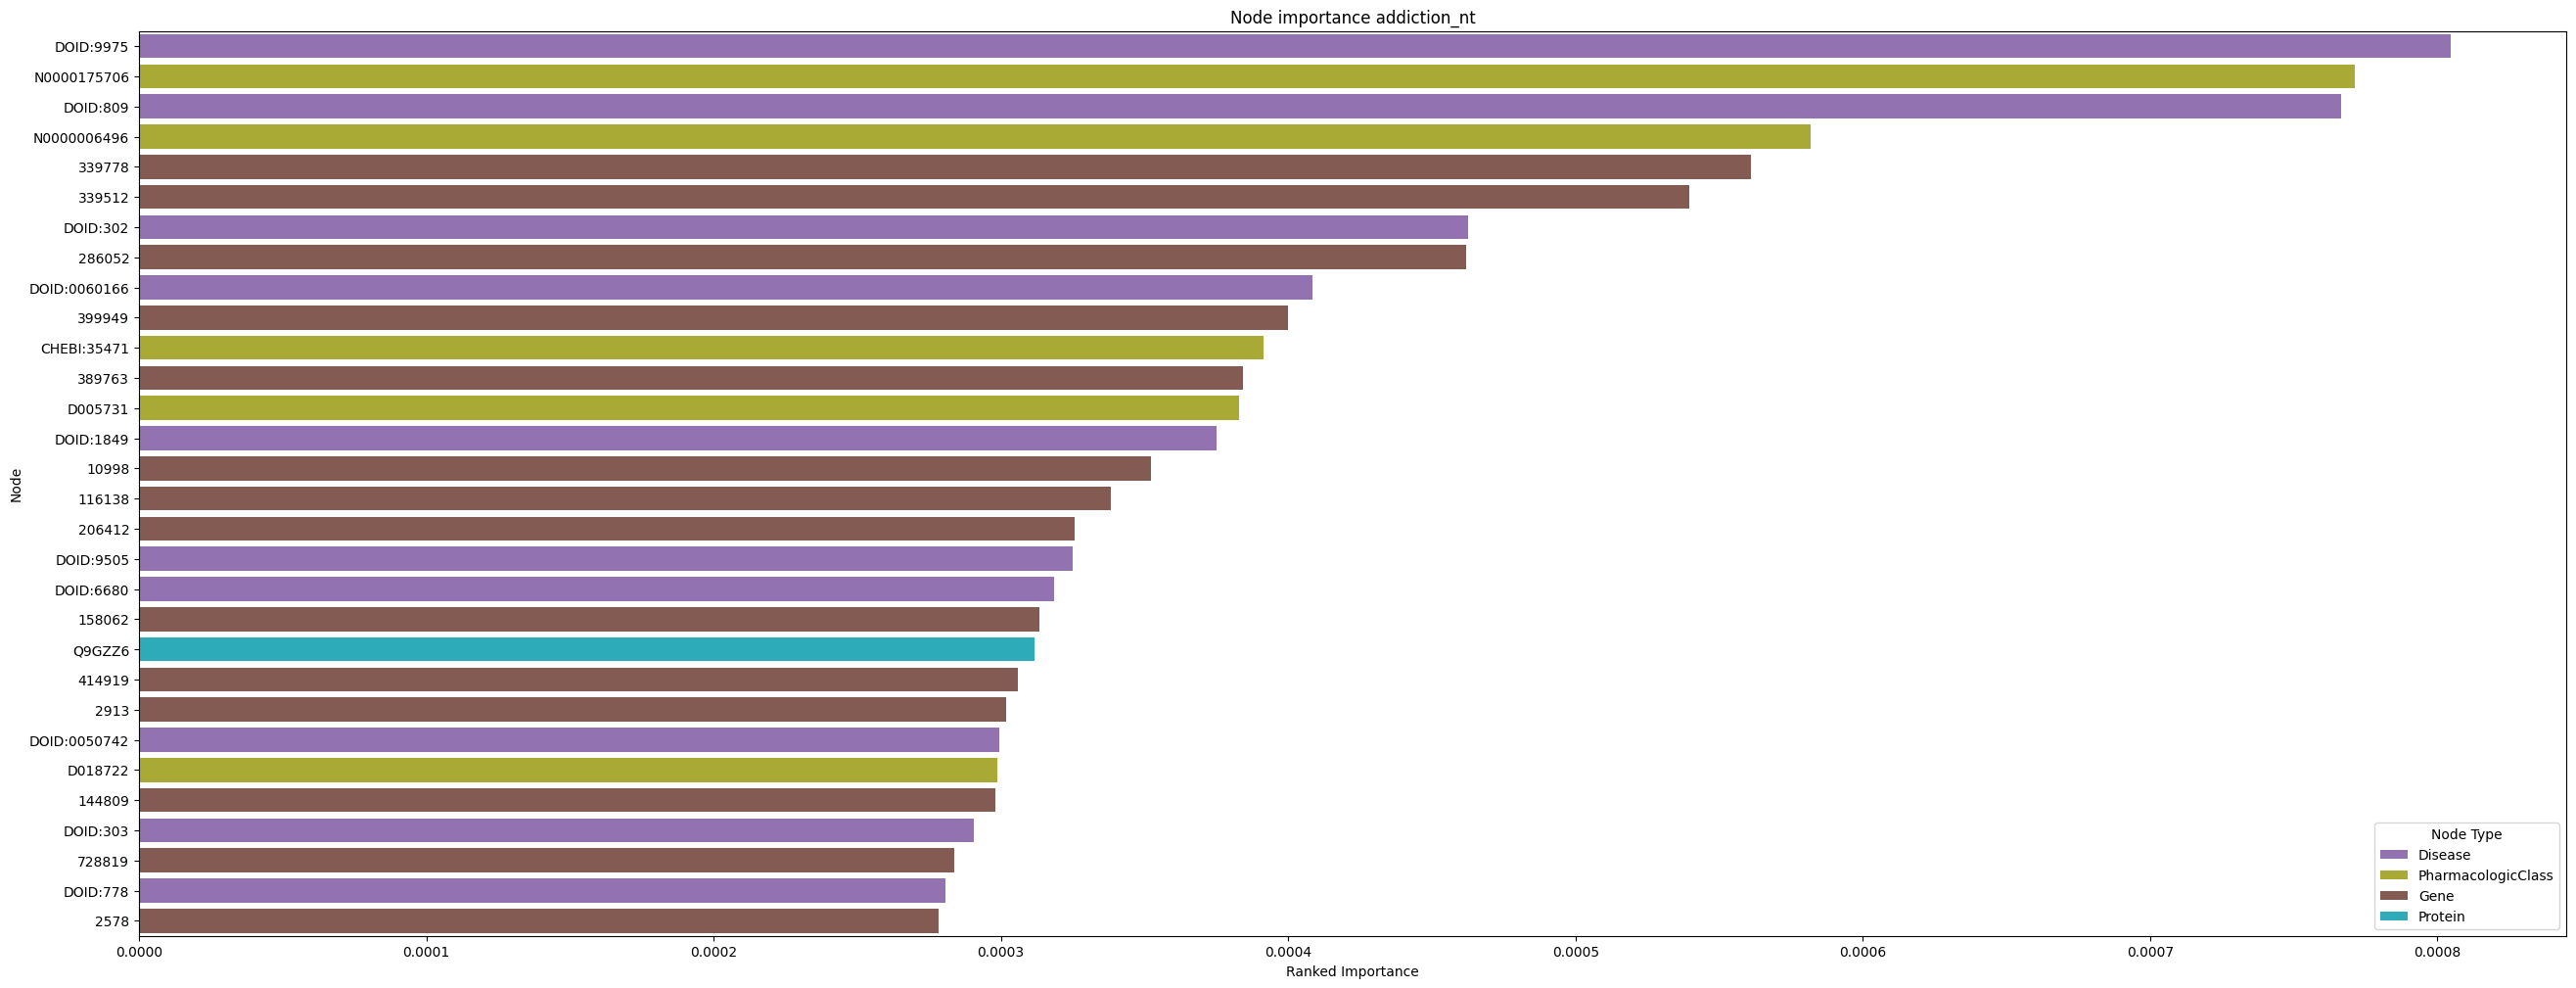

In [45]:
create_barchart(addiction_nt, 30, 'addiction_nt')

/tmp/ipykernel_30397/1879966463.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='node', data=datatable.iloc[:n_nodes], palette=colors, dodge=False)


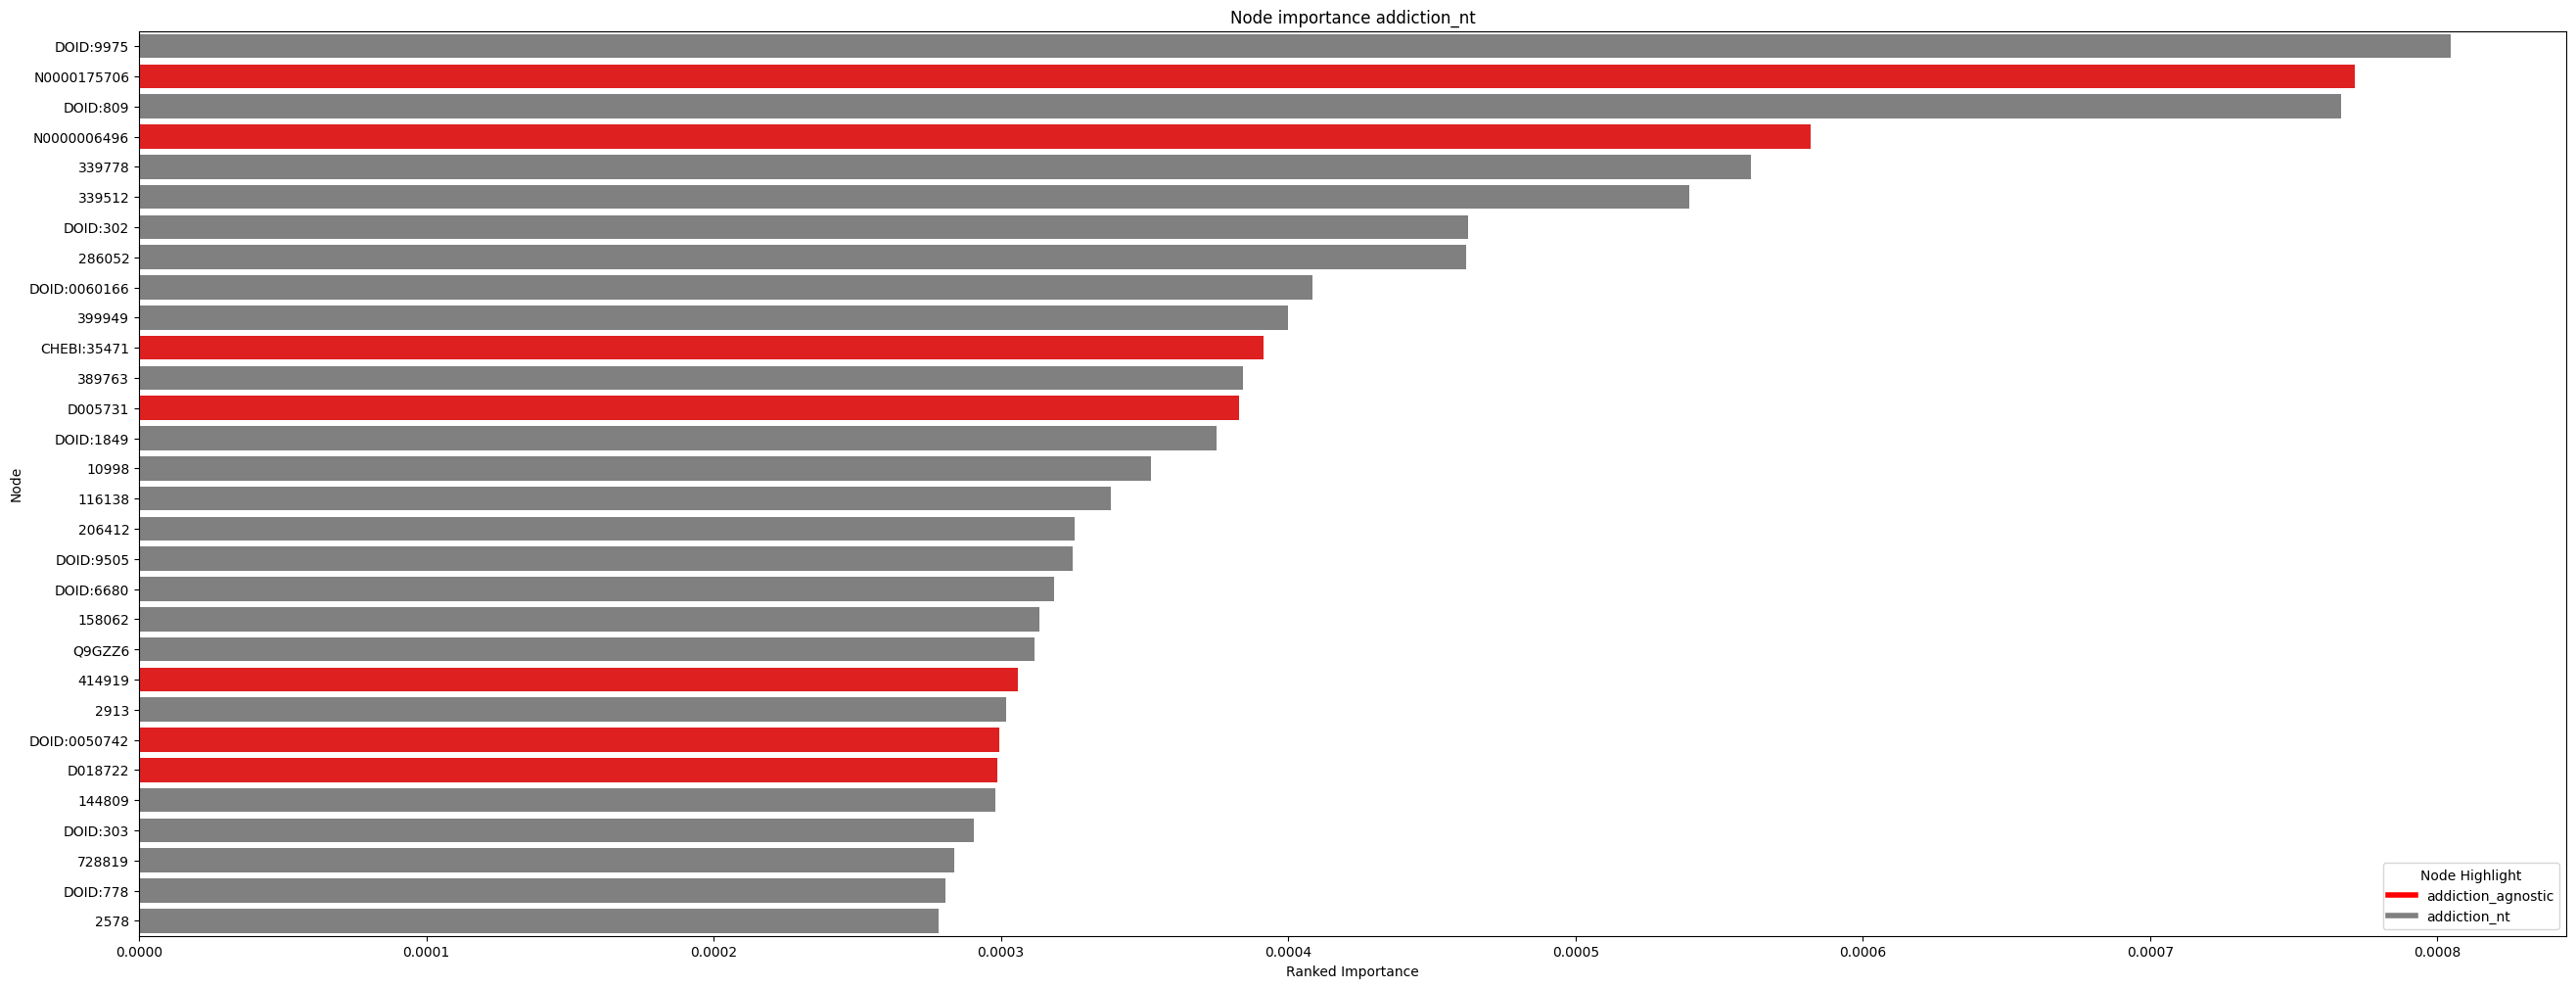

In [46]:
create_barchart(addiction_nt, 30, 'addiction_nt', list(common_features_nt['node']))

# Interrogate why so much sperm stuff

In [54]:
import pymssql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from psmpy import PsmPy
import numpy as np
from tqdm import tqdm

from dateutil.relativedelta import relativedelta

#Set up OMOP database connection

config = configparser.ConfigParser()
config.read('omop_db_config_new.ini')

db_host = config['database']['host']
db_user = config['database']['user']
db_password = config['database']['password']
db_name = config['database']['dbname']

sql_conn = pymssql.connect(db_host, db_user, db_password, db_name)
cursor = sql_conn.cursor(as_dict=True)

#Functions to query db
def get_data(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    results = cursor.fetchall()
    columns = [column[0] for column in cursor.description]
    df = pd.DataFrame(results, columns=columns)
    return df

def run_query(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    return None

In [61]:
addiction_cohort = pd.read_feather('data/opioid_cohort_details.feather')

#Create Table with addicted patient IDs
op_addicted_ids = addiction_cohort.person_id.to_list()
op_addicted_ids = '), ('.join([str(subject_ids) for subject_ids in op_addicted_ids])
op_addicted_ids = '(' + op_addicted_ids + ')'
op_addicted_ids = op_addicted_ids.split(', ')

query_op_ids = f"""
DROP TABLE IF EXISTS #op_addicted_patient_ids;
CREATE TABLE #op_addicted_patient_ids (person_id INT);
"""

for subject_id in op_addicted_ids:
    query_op_ids += f"""
INSERT INTO #op_addicted_patient_ids (person_id)
VALUES {subject_id};
"""
    
run_query(sql_conn, query_op_ids)

#Add age and sex info to table
op_bio_query = """
SELECT
    p.person_id, 
    p.gender_source_value, 
    2024 - p.year_of_birth AS age, 
    p.ethnicity_source_value

FROM
    #op_addicted_patient_ids op
    
    JOIN [person] p
        ON op.person_id = p.person_id
"""

addiction_cohort = addiction_cohort.merge(get_data(sql_conn, op_bio_query), on = 'person_id', how = 'left')

In [62]:
addiction_cohort.groupby('gender_source_value').count()

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent,cutoff_date,age,ethnicity_source_value
gender_source_value,,,,,,,,,,,
Female,10444,10444,10444,10444,10444,593,10444,10444,10444,10444,10444
Male,7359,7359,7359,7359,7359,519,7359,7359,7359,7359,7359
Nonbinary,7,7,7,7,7,1,7,7,7,7,7


In [64]:
control_cohort = pd.read_feather('data/not_op_addicted.feather')

#Create Bio table for non-addicted population
not_op_addicted_ids = control_cohort.person_id.to_list()
not_op_addicted_ids = '), ('.join([str(subject_ids) for subject_ids in not_op_addicted_ids])
not_op_addicted_ids = '(' + not_op_addicted_ids + ')'
not_op_addicted_ids = not_op_addicted_ids.split(', ')

query_not_op_ids = f"""
DROP TABLE IF EXISTS #not_op_addicted_patient_ids;
CREATE TABLE #not_op_addicted_patient_ids (person_id INT);
"""

for subject_id in not_op_addicted_ids:
    query_not_op_ids += f"""
INSERT INTO #not_op_addicted_patient_ids (person_id)
VALUES {subject_id};
"""
    
run_query(sql_conn, query_not_op_ids)

#Add age and sex info to table
n_op_bio_query = """
SELECT
    p.person_id, p.gender_source_value, 
    2024 - p.year_of_birth AS age, 
    p.ethnicity_source_value

FROM
    #not_op_addicted_patient_ids n_op
    
    JOIN [person] p
        ON n_op.person_id = p.person_id
"""

control_cohort = control_cohort.merge(get_data(sql_conn, n_op_bio_query), on = 'person_id', how = 'left')

In [66]:
control_cohort.groupby('gender_source_value').count()

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent,age,ethnicity_source_value
gender_source_value,,,,,,,,,,
Female,63943,63943,63943,63943,63943,0,63943,63943,63943,63943
Male,44625,44625,44625,44625,44625,0,44625,44625,44625,44625
Nonbinary,36,36,36,36,36,0,36,36,36,36
Unknown,17,17,17,17,17,0,17,17,17,17
